# Automatically label lab data

This notebook uses a combination of computer vision techniques, namely adaptive thresholding, morpholohy, and a conditional random field (CRF) to automatically segment the mussels on the black board with white lines in the lab.

To do:
- estimate number of pixels per square to correct for camera distance
- Lab_3800-3_2018-08-13, crop too much from top
- Lab_3784-2_2018-07-05, junk on top

In [4]:
import os
import os.path as osp
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

%matplotlib inline

In [2]:
#!pip install pydensecrf

In [6]:
DATA_PATH = osp.join(os.environ['DATA_PATH'], 'cciw/Data')
#SAVE_PATH = osp.join(os.environ['DATA_PATH'], 'cciw/dataset_raw/Test/Lab/done')

In [7]:
imagetable_path = os.path.join(DATA_PATH, 'Tables', 'ImageTable.csv')
image_df = pd.read_csv(imagetable_path, index_col=0)
analysis_path = os.path.join(DATA_PATH, 'Tables', 'Analysis.csv')
dive_path = os.path.join(DATA_PATH, 'Tables', 'Dives.csv')
analysis_df = pd.read_csv(analysis_path, index_col=0, dtype={'Count':float})
dive_df = pd.read_csv(dive_path, index_col=0, parse_dates=['Date'])
data_df = pd.merge(analysis_df, dive_df, on='Dive Index', how='outer')

In [8]:
# Search for all image files in testing set...
all_images = glob(os.path.join(DATA_PATH,'Videos_and_stills/TestingSet/Lab/*/*/*/Images/Quad*/*.jpg'))
len(all_images)

40

In [13]:
#all_images

In [10]:
import PIL.Image


def lblsave(filename, lbl):
    import imgviz

    if osp.splitext(filename)[1] != '.png':
        filename += '.png'
    # Assume label ranges [-1, 254] for int32,
    # and [0, 255] for uint8 as VOC.
    if lbl.min() >= -1 and lbl.max() < 255:
        lbl_pil = PIL.Image.fromarray(lbl.astype(np.uint8), mode='P')
        colormap = imgviz.label_colormap()
        lbl_pil.putpalette(colormap.flatten())
        lbl_pil.save(filename)
    else:
        raise ValueError(
            '[%s] Cannot save the pixel-wise class label as PNG. '
            'Please consider using the .npy format.' % filename
        )

# meta-parameters

In [14]:
'''
@param blockSize Size of a pixel neighborhood 
       that is used to calculate a threshold value for the pixel.
@param C Constant subtracted from the mean or weighted mean 
       (see the details below). Normally, it is positive but may be zero 
       or negative as well.
@param k_size morphology structuring element size
'''
blockSize  = 301
C_constant = 2
k_size     = 11

min_area = 40000
max_area = 300000

corn = 450
buf = 100
bottom_cut = 150
horiz_cut = 200
right_cut = 100

# HoughLinesP
rho = 10
theta = np.pi / 45
threshold = 500
mLL = 500
mLG = 20

# Show results along the way
DO_PLOT = False

# Run conditional random field post processing to retrieve missing shell pieces
DO_CRF = False # can increase processing time by 20 seconds per image
MAX_ITER = 10

In [15]:
k_25 = np.ones((25, 25), np.uint8)
k_120 = np.ones((120, 120), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_size, k_size))

pix_ct = []
for i in tqdm(range(len(all_images))):
    im   = cv2.imread(all_images[i])
    rgb  = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    th1  = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize, C_constant)
    erosion = cv2.erode(th1, kernel, iterations=2)
    close = cv2.dilate(erosion, kernel, iterations=1)
    '''
    @param mode cv2.RETR_EXTERNAL retrieves only the extreme outer contours.
    @param method cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, 
           and diagonal segments and leaves only their end points. For example, 
           an up-right rectangular contour is encoded with 4 points.
    '''
    cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        area = cv2.contourArea(c)
        if area > min_area: #and area < max_area:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(rgb, (x, y), (x + w, y + h), (36, 255, 12), 5)
            close[y:y+h, x:x+w] = 0

    if DO_PLOT:
        fig, axes = plt.subplots(1, 2, figsize=(16, 12))

    close[:, :horiz_cut] = 0
    close[:, close.shape[1] - right_cut:] = 0
    close[close.shape[0] - bottom_cut:, :] = 0
    close[:bottom_cut, :] = 0
    close = cv2.dilate(close, kernel, iterations=1)

    # to remove leftover dots
    t = cv2.erode(close, k_25, iterations=1)
    mask = cv2.dilate(t, k_120, iterations=1)
    seg_mask = close & mask
    _, cts = np.unique(seg_mask, return_counts=True) 

    # may find spurious lines if more than 2M pixels
    if cts[1] < 2000000:
        linesP = cv2.HoughLinesP(seg_mask, rho, theta, threshold=threshold, minLineLength=mLL, maxLineGap=mLG)
        if linesP is not None:
            for j in range(len(linesP)):
                l = linesP[j][0]
                if np.abs(l[1] - l[3]) < 50:
                    #print(i, 'found horiz line: ', j)
                    x_start = np.minimum(l[0], l[2])
                    x_end = np.maximum(l[0], l[2])
                    seg_mask[l[3] - buf:l[1] + buf, 
                             np.maximum(x_start - buf * 10, 0):np.minimum(
                                 x_end + buf * 10, seg_mask.shape[1])] = 0

    # upper left corner
    seg_mask[:corn, :corn] = 0
    # upper right corner
    seg_mask[:corn, seg_mask.shape[1]-corn:] = 0
    # bottom left corner
    seg_mask[seg_mask.shape[0]-corn:, :corn] = 0
    # bottom right corner
    seg_mask[seg_mask.shape[0]-corn:, seg_mask.shape[1]-corn:] = 0

    # CRF Post-processing
    if DO_CRF:
        img = np.ascontiguousarray(rgb)
        labels = np.stack([seg_mask, 1 - seg_mask])
        c, h, w = labels.shape[0], labels.shape[1], labels.shape[2]
        labels = labels.astype('float') / labels.max()

        U = utils.unary_from_softmax(labels)
        U = np.ascontiguousarray(U)
        d = dcrf.DenseCRF2D(w, h, c)
        d.setUnaryEnergy(U)
        """
        @param compat=3, Potts model - it introduces a penalty for nearby similar 
        pixels that are assigned different labels. 
        """
        # This adds the color-independent term, features are the locations only.
        d.addPairwiseGaussian(sxy=3, compat=3)
        # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
        # im is an image-array, e.g. im.dtype == np.uint8
        d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=img, compat=10)
        Q = d.inference(MAX_ITER)
        Q = np.array(Q).reshape((c, h, w))
        # binarize output
        Q[0][Q[0] >= 0.5] = 1
        Q[0][Q[0] < 0.5] = 0
        crf_mask = (Q[0] * 255).astype('uint8')
        _, cts = np.unique(crf_mask, return_counts=True)

    pix_ct.append(cts[1] / cts.sum())

    if DO_PLOT:
        axes[0].set_title(str(i))
        axes[0].imshow(rgb)
        axes[1].imshow(seg_mask)
        for k in range(len(axes.flat)):
            axes.flat[k].axis('off')
        plt.show()

    mask_file = os.path.join(SAVE_PATH, all_images[i].split('/')[-1].split('.')[0] + '_mask.png')
    jpeg_file = os.path.join(SAVE_PATH, all_images[i].split('/')[-1])
    #cv2.imwrite(mask_file, seg_mask)
    #cv2.imwrite(jpeg_file, im)
    #lbl = np.zeros((np_img.shape[0], np_img.shape[1]))
    #lbl[(np_img[:, :, 2] ==  60)] = 1
    seg_mask[seg_mask == 255] = 1
    lblsave(mask_file, seg_mask) # save as indexed color RGB image

    if DO_CRF:
        crf_mask_file = os.path.join(SAVE_PATH, all_images[i].split('/')[-1].split('.')[0] + '_mask_crf.png')
        crf_mask[crf_mask == 255] = 1
        lblsave(crf_mask_file, crf_mask) # save as indexed color RGB image
        #cv2.imwrite(crf_mask_file, crf_mask)

100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


In [ ]:
#np.unique(seg_mask)

# Compare biomass and fraction of mussel pixels

In [16]:
pix_ct = np.asarray(pix_ct)
lab_targets = np.zeros((len(all_images), 2)) # 0 = biomass, 1 = count

for i in range(len(all_images)):
    root_fname = all_images[i].split('/')[-1].split('.')[0][4:-8]
    guid = image_df[image_df['Name'].str.contains(root_fname)]['Analysis Index'].astype('int64')
    row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
    lab_targets[i, 0] = row['Biomass'].values
    lab_targets[i, 1] = row['Count'].values

lab_targets[np.isnan(lab_targets)] = 0
y = lab_targets[:, 0] / lab_targets[:, 0].max()
r_val = np.corrcoef(pix_ct, y)[1, 0]

A = np.vstack([pix_ct, np.ones(len(pix_ct))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

In [21]:
import matplotlib
# enable LaTeX style fonts
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# evaluation metrics
from sklearn.metrics import r2_score


def linear_regression(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    (m, c), res, r, s = np.linalg.lstsq(A, y, rcond=-1)
    std = np.sqrt(res[0] / len(y))
    return m * x + c

In [20]:
m * x + c

array([-0.0681291 , -0.04965173, -0.03117437, -0.01269701,  0.00578035,
        0.02425771,  0.04273507,  0.06121244,  0.0796898 ,  0.09816716,
        0.11664452,  0.13512188,  0.15359924,  0.17207661,  0.19055397,
        0.20903133,  0.22750869,  0.24598605,  0.26446341,  0.28294078,
        0.30141814,  0.3198955 ,  0.33837286,  0.35685022,  0.37532759,
        0.39380495,  0.41228231,  0.43075967,  0.44923703,  0.46771439,
        0.48619176,  0.50466912,  0.52314648,  0.54162384,  0.5601012 ,
        0.57857856,  0.59705593,  0.61553329,  0.63401065,  0.65248801,
        0.67096537,  0.68944274,  0.7079201 ,  0.72639746,  0.74487482,
        0.76335218,  0.78182954,  0.80030691,  0.81878427,  0.83726163])

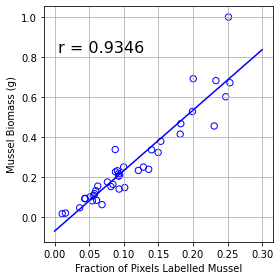

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(pix_ct, y, marker='o', s=40, facecolors='none', edgecolors='b')
ax.set_ylabel('Mussel Biomass (g)')
#ax.set_xlim(0, 1.05)
ax.set_xlabel('Fraction of Pixels Labelled Mussel')

x = np.linspace(0, 0.3)
ax.plot(x, m*x + c, 'b', linestyle='-')
ax.annotate(r'r = %.4f' % r_val, xy=(.06, .805), fontsize=16, xycoords='axes fraction')

ax.grid()
fname = 'TestingSet_Lab_biomass_v_fract_mussel_pixels_v2'

plt.tight_layout()
fig.savefig(fname + '.png')
#fig.savefig(fname + '.eps', format='eps')

# CRF Stratch Space

In [ ]:
%matplotlib notebook

In [ ]:
seg_mask = seg_mask[:-273, 1250:3250]
mask = mask[:-273, 1250:3250]
rgb = rgb[:-273, 1250:3250, :]
w = 640
seg = cv2.resize(seg_mask, (w, w))
rgb = cv2.resize(rgb, (w, w))
msk = cv2.resize(mask, (w, w))

In [ ]:
seg = seg_mask.copy()

In [ ]:
rgb.shape

In [ ]:
seg.shape

In [ ]:
#imask = np.invert(msk).astype('bool')
#imask.shape

In [ ]:
#imask.astype('bool').shape

In [ ]:
#rgb[imask] = 0

In [ ]:
#plt.imshow(rgb)

In [ ]:
#w = 640
#seg = cv2.resize(seg_mask, (w, w))
#rgb = cv2.resize(rgb, (w, w))
img = np.ascontiguousarray(rgb)

In [ ]:
img.shape

In [ ]:
img = np.ascontiguousarray(rgb)
labels = np.stack([seg, 1 - seg])
c = labels.shape[0]
h = labels.shape[1]
w = labels.shape[2]
labels = labels.astype('float') / labels.max()

U = utils.unary_from_softmax(labels)
U = np.ascontiguousarray(U)
d = dcrf.DenseCRF2D(w, h, c)
d.setUnaryEnergy(U)
MAX_ITER = 10
POS_W = 3
POS_XY_STD = 10
Bi_W = 40
Bi_XY_STD = 67
Bi_RGB_STD = 30

# This adds the color-independent term, features are the locations only.
"""
@param compat=3, Potts model - it introduces a penalty for nearby similar 
pixels that are assigned different labels. 
"""
d.addPairwiseGaussian(sxy=3, compat=3)
# This adds the color-dependent term, i.e. features are (x,y,r,g,b).
# im is an image-array, e.g. im.dtype == np.uint8 and im.shape == (640,480,3)
d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=img, compat=10)
Q = d.inference(MAX_ITER)
Q = np.array(Q).reshape((c, h, w))

crf_mask = (Q[0] * 255).astype('uint8')
crf_mask_file = os.path.join(SAVE_PATH, all_images[i].split('/')[-1].split('.')[0] + '_mask_crf.png')
cv2.imwrite(crf_mask_file, fmask)

addPairwiseGaussian
- `sxy` = $\theta_{\gamma}$, smoothness kernel

addPairwiseBilateral
- `sxy` = $\theta_{\alpha}$, appearance kernel
- `srgb` = $\theta_{\beta}$, appearance kernel 

In [ ]:
font=28
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
axes[0].imshow(rgb)
axes[0].set_title('RGB input', fontsize=font)
axes[1].imshow(seg)
axes[1].set_title('Rough mask', fontsize=font)
#Q[0][Q[0] >= 0.5] = 1
#Q[0][Q[0] < 0.5] = 0
axes[2].imshow(Q[0])
axes[2].set_title('CRF output', fontsize=font)

for i in range(len(axes)):
    axes[i].axis('off')

#plt.tight_layout()
#fig.savefig(all_images[i].split('/')[-1].split('.')[0] + '_CRF_1x3.png')

In [ ]:
%matplotlib notebook
#all_images[i].split('/')[-1].split('.')[0]

In [ ]:
#fmask = Q[0].astype()
#Q[0][Q[0] >= 0.5] = 1
#Q[0][Q[0] < 0.5] = 0
fmask = (Q[0] * 255).astype('uint8')

In [ ]:
crf_mask_file = os.path.join(SAVE_PATH, all_images[i].split('/')[-1].split('.')[0] + '_mask_crf.png')
cv2.imwrite(crf_mask_file, fmask)

In [ ]:
seg_mask_bak = seg_mask.copy()

In [ ]:
seg_mask = seg_mask_bak.copy()

In [ ]:
rho = 10  
theta = np.pi / 45
threshold = 500
mLL = 500
mLG = 20
linesP = cv2.HoughLinesP(seg_mask, rho, theta, threshold=threshold, minLineLength=mLL, maxLineGap=mLG)
print(len(linesP))

In [ ]:
plt.imshow(seg_mask)

In [ ]:
#len(linesP)
buf = 1000

In [ ]:
line_width = 10
#N = 5
if linesP is not None:
    for i in range(len(linesP)):
        l = linesP[i][0]
        pt1 = (l[0], l[1])
        pt2 = (l[2], l[3])
        if np.abs(l[1] - l[3]) < 50:
            print('Found horiz line', pt1, pt2)
            cv2.line(rgb, pt1, pt2, (255, 0, 255), line_width, cv2.LINE_AA)
            seg_mask[l[3] - buf:l[1] + buf, l[0] - buf * 4:l[2] + buf * 4] = 0
plt.figure(figsize=(14, 10))
plt.imshow(rgb)

In [ ]:

#pix_ct = pix_ct / pix_ct.max()

In [ ]:
import scipy.stats as ss
from scipy.stats.distributions import t

In [ ]:
all_images[0].split('/')[-1].split('.')[0][4:-8]

In [ ]:
root_fname = all_images[0].split('/')[-1].split('.')[0][4:-8]
guid = image_df[image_df['Name'].str.contains(root_fname)]['Analysis Index'].astype('int64')
row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
lab_targets[i, 0] = row['Biomass'].values
lab_targets[i, 1] = row['Count'].values

In [ ]:
#lab_targets

In [ ]:
#v, cts = np.unique(mask, return_counts=True)
#print(cts)

In [ ]:
cts[1]

In [ ]:
good = close.copy()

In [ ]:
k_size = 25
kernel = np.ones((k_size, k_size), np.uint8)
t = cv2.erode(close, kernel, iterations=1)

k_size = 120
kernel = np.ones((k_size, k_size), np.uint8)
mask = cv2.dilate(t, kernel, iterations=1)

In [ ]:
plt.imshow()

In [ ]:
#plt.imshow(erosion)

In [ ]:
close.shape

In [ ]:
mask

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
axes[0].imshow(close)
#clean_mask = close[mask == 1] = 1
axes[1].imshow(mask)
for i in range(len(axes.flat)):
    axes.flat[i].axis('off')
plt.show() #pause(0.1)

In [ ]:
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import pickle

from pystruct import learners
import pystruct.models as crfs
from pystruct.utils import SaveLogger

In [ ]:
!pip install cvxopt

In [ ]:
data_train['X'][:10][0][0].shape

In [ ]:
#data_train['Y'][:10][0][0]

In [ ]:
#data_train = pickle.load()
# https://rebeccabilbro.github.io/convert-py2-pickles-to-py3/
with open('/scratch/ssd/data/CRF_Tut/data_train.pickle', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')

In [ ]:
#data_train = pickle.load(open("/scratch/ssd/data/CRF_Tut/data_train.pickle"))
C = 0.01

n_states = 21
print("number of samples: %s" % len(data_train['X']))
class_weights = 1. / np.bincount(np.hstack(data_train['Y']))
class_weights *= 21. / np.sum(class_weights)
print(class_weights)

model = crfs.EdgeFeatureGraphCRF(inference_method='qpbo',
                                 class_weight=class_weights,
                                 symmetric_edge_features=[0, 1],
                                 antisymmetric_edge_features=[2])

experiment_name = "edge_features_one_slack_trainval_%f" % C

ssvm = learners.NSlackSSVM(
    model, verbose=2, C=C, max_iter=100000, n_jobs=-1,
    tol=0.0001, show_loss_every=5,
    logger=SaveLogger(experiment_name + ".pickle", save_every=100),
    inactive_threshold=1e-3, inactive_window=10, batch_size=100)

ssvm.fit(data_train['X'], data_train['Y'])

data_val = pickle.load(open("data_val_dict.pickle"))
y_pred = ssvm.predict(data_val['X'])

# we throw away void superpixels and flatten everything
y_pred, y_true = np.hstack(y_pred), np.hstack(data_val['Y'])
y_pred = y_pred[y_true != 255]
y_true = y_true[y_true != 255]

print("Score on validation set: %f" % np.mean(y_true == y_pred))

In [ ]:
learners.NSlackSSVM?

In [ ]:
#!pip install pyqpbo

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

In [ ]:
segments = slic(rgb, 1000)
#slic?

In [ ]:
rgbb = mark_boundaries(rgb, segments, color=(0,0,0))

In [ ]:
plt.figure()
plt.imshow(rgbb)
plt.show()

In [ ]:
%matplotlib

In [ ]:
plt.imshow(np.invert(mask))

In [ ]:
rgb[np.invert(mask), :].shape # = 0

In [ ]:
plt.imshow(rgb)

In [ ]:
#mask.shape

In [ ]:
np.unique(mask)

In [ ]:
rgb.shape